## Validation analysis against open/closed cells
---------------
This notebook focuses on the validation analysis, which includes inference of trained model with lablled input data and clustering against the output of model.

--------------
### Load module

In [1]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from math import ceil,sqrt
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
## directory where your put lib_hdfs
libdir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [30]:
sys.path.insert(1,os.path.join(sys.path[0],libdir)) # this line helps you to use your own functions in another directory
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array
from analysis_lib import *

### Load Model

In [4]:
homedir = '/home/rubywerman/scratch-midway2/lib_hdfs'
datadir = homedir+"/model/m2_02_global_2000_2018_band28_29_31"
step = 100000 # DONOT change so far

In [5]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

W0729 13:19:20.512195 140336651073344 deprecation.py:506] From /home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0729 13:19:20.513895 140336651073344 deprecation.py:506] From /home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it.

### Load labelled open/closed cell

Load the date files of your labeled patches here. You can get these files from running and labeling patches in cloud_labeling.ipynb

In [6]:
#enter the name of the directory containing your dates files, mod02, and mod35 data for your labeled patches
filesdir = "/home/rubywerman/clouds/src_analysis/labeled_data/class_patch_data/"

The following are patch and cluster objects that make it easy to access and write new data 

In [7]:
class Patch:        
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None, has_coord=False, coords=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature
        self.has_coord = has_coord
        self.coords = coords
        
    def print_attr(self):
        print("date: " + self.date)
        print("isOpen: " + str(self.isOpen))
        print("label: " + str(self.label))
        if len(self.coords) > 0:
            print("coords: ")
            for i in self.coords:
                print(str(i))   
        
class Cluster:
    def __init__(self, label, patches=None, means=None, std=None, num_open=0):
        self.label = label
        self.patches = patches
        self.means = means
        self.std = std
        self.num_open = num_open

Run the cell below to load in your list of patch objects from `cloud_labeling.ipynb`

In [8]:
class_patch_list = np.load(filesdir + '072219.npy')
#clean faulty patches
class_patch_list = [patch for patch in class_patch_list if type(patch.zeroTwo) is not list]

In [9]:
print("Number of patches recorded: " + str(len(class_patch_list)))

Number of patches recorded: 36


### Run Analysis

we will use a type of hierarchical clusering called `Agglometative clustering` 

How to donwload agglomerative [sklearn aggl](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  

`from sklearn.cluster import AgglomerativeClustering`

###### Inference

In [10]:
encs_list = []
for patch in class_patch_list:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list += [encs.mean(axis=(1,2))]

In [11]:
features = np.concatenate(encs_list, axis=0)

In [12]:
print(features.shape)  # make sure, the shape is [#number of patches, 128]

(36, 128)


##### Clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering

In [204]:
# N in [2, inf), you can change this number but save the result differently
num_clusters = 4

In [205]:
clustering = AgglomerativeClustering(num_clusters)

In [206]:
#turns any NAN values to 0 so code doesn't crash
cleaned_features = np.nan_to_num(features)

In [207]:
#generate clustering data
label = clustering.fit_predict(cleaned_features)

In [208]:
#assign each patch instance its correct label
for i in range(len(class_patch_list)):
    class_patch_list[i].label = label[i]

In [209]:
#make a list of clusters
list_clusters = [Cluster(label=i) for i in range(num_clusters)]

In [210]:
#add patches to cluster objects
for p in class_patch_list:
    matching_cluster = list_clusters[p.label]
    if p.isOpen:
        matching_cluster.num_open += 1
    if not matching_cluster.patches:
        matching_cluster.patches = [p]
    else:
        matching_cluster.patches.append(p)

## Visualize clustering accuracy

Visualize how open and closed clusteres are differently classified. Run this section to create a stacked bar graph of the clusters and a t-Distributed Stochastic Neighbor Embedding (t-SNE) plot.

In [211]:
save_path = '/home/rubywerman/to_export/'
if not os.path.exists(save_path + str(num_clusters)):
    os.mkdir(save_path + str(num_clusters))
to_save = save_path + str(num_clusters) + '/'

In [212]:
open_clusters = [c.num_open for c in list_clusters]
closed_clusters = [len(c.patches) - c.num_open for c in list_clusters]

W0729 14:24:20.883548 140336651073344 legend.py:1282] No handles with labels found to put in legend.


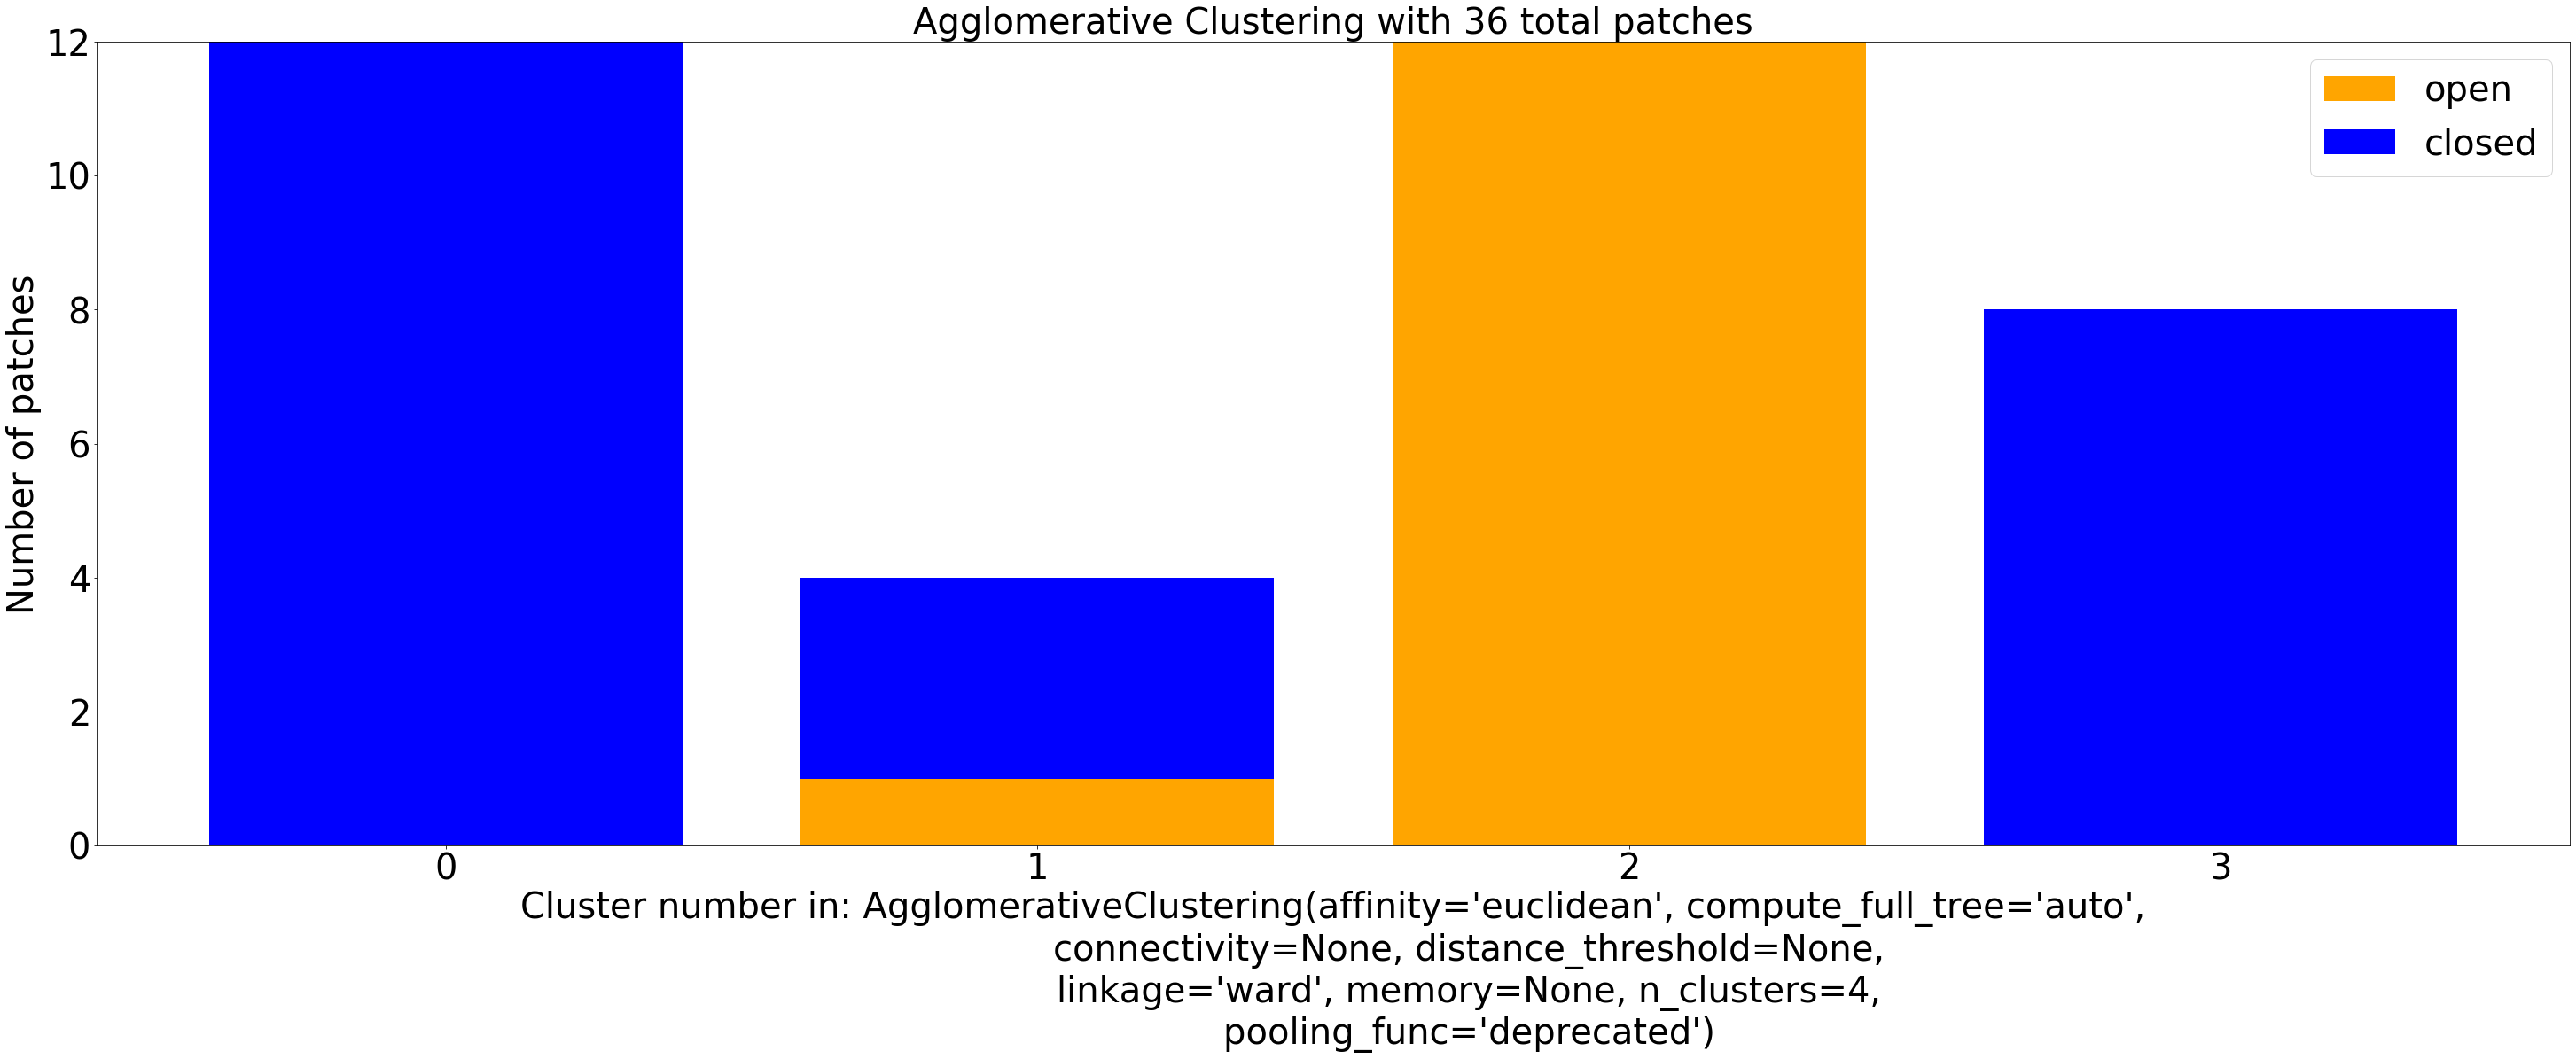

In [213]:
#create stacked bar graph 
from matplotlib import rc

plt.figure(figsize=(50,20))

# Heights of bars
bars = [len(open_clusters), len(closed_clusters)]

# The position of the bars on the x-axis
r = range(num_clusters)

# Label for each bar and bar width
x_labels = [str(i) for i in r]
barWidth = .8

# Create open-classified bars
plt.bar(r, open_clusters, color='orange', width=barWidth)

# Stack bars
plt.bar(r, closed_clusters, bottom=open_clusters, color='blue', width=barWidth)

# label/title graph
plt.xticks(r, x_labels, fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel("Number of patches", fontsize=40)
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
plt.legend(loc="upper right")
plt.legend(('open','closed'), fontsize=40)
plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
plt.gcf().subplots_adjust(bottom=0.25)
    
    
    
#save image
plt.savefig(to_save + '%d_cluster_plot.png'%(num_clusters))

# Show graphic
plt.show()

In [214]:
#visualize t-SNE 
cloud_tsne = TSNE().fit_transform(cleaned_features)

In [215]:
import random
def get_rand_colors(n=10, cmap_name='jet', _seed = 12356):
    #colormap
    cmap = cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        colors += [matplotlib.colors.rgb2hex(rgb)]
    # shuffle
    random.seed(_seed)
    random.shuffle(colors)
    return colors

In [216]:
import matplotlib.patches as mpatches
def cloud_scatter(x, label):
    """
    @source: https://www.datacamp.com/community/tutorials/introduction-t-sne
    Utility function to visualize the outputs of t-SNE
    
    Inputs:
    x: a 2d numpy array containing the output of the t-SNE algorithm
    label: a 1d numpy array containing the labels of the dataset
    
    Outputs:
    None– Creates a scatterplot with as many unique colors as the number of clusters
    """
    #make a color palette with seaborn
    num_colors = len(np.unique(label))
    palette = np.array(get_rand_colors(num_colors))
    #palette = np.array(sns.color_palette("hls", num_colors))

    #make scatter plot
    fig, ax = plt.subplots(figsize=(50,25))
    scatter = ax.scatter(x[:,0], x[:,1], s=35**2, c=palette[label])

    # plot each category with a distinct label
    classes = [str(i) for i in range(num_clusters)]
    recs = []
    for i in range(num_clusters):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=palette[i]))
    ax.legend(recs,classes,loc='best', fontsize=25)
    
    ##If you want text lables at the median of data points, uncomment the following code 
    #for i in range(num_colors):
        ## Position of each label at median of data points.
        #xtext, ytext = np.median(x[label == i, :], axis=0)
        #txt = ax.text(xtext, ytext, str(i), fontsize=40)
        #txt.set_path_effects([
            #PathEffects.Stroke(linewidth=5, foreground="w"),
            #PathEffects.Normal()])
        #txts.append(txt)
        
    ##Adds a cluster label to every point on the plot. Useful for many clusters when colors can be hard to tell from each other
    #txts = []
    #for i in range(num_colors):
        #cluster = x[label == i, :]
        #for patch in cluster:
            #xtext, ytext = patch
            #txt = ax.text(xtext, ytext, str(i), fontsize=45)
            #txt.set_path_effects([
                #PathEffects.Stroke(linewidth=5, foreground="w"),
                #PathEffects.Normal()])
            #txts.append(txt)    
            
    ax.axis('off')
    plt.title("Visualization of %d patches in %s clusters produced by t-SNE"%(len(label), num_clusters), fontsize=40)
    plt.savefig(to_save + '%d_tsne.png'%(num_clusters))
    
    # Show graphic
    plt.show()

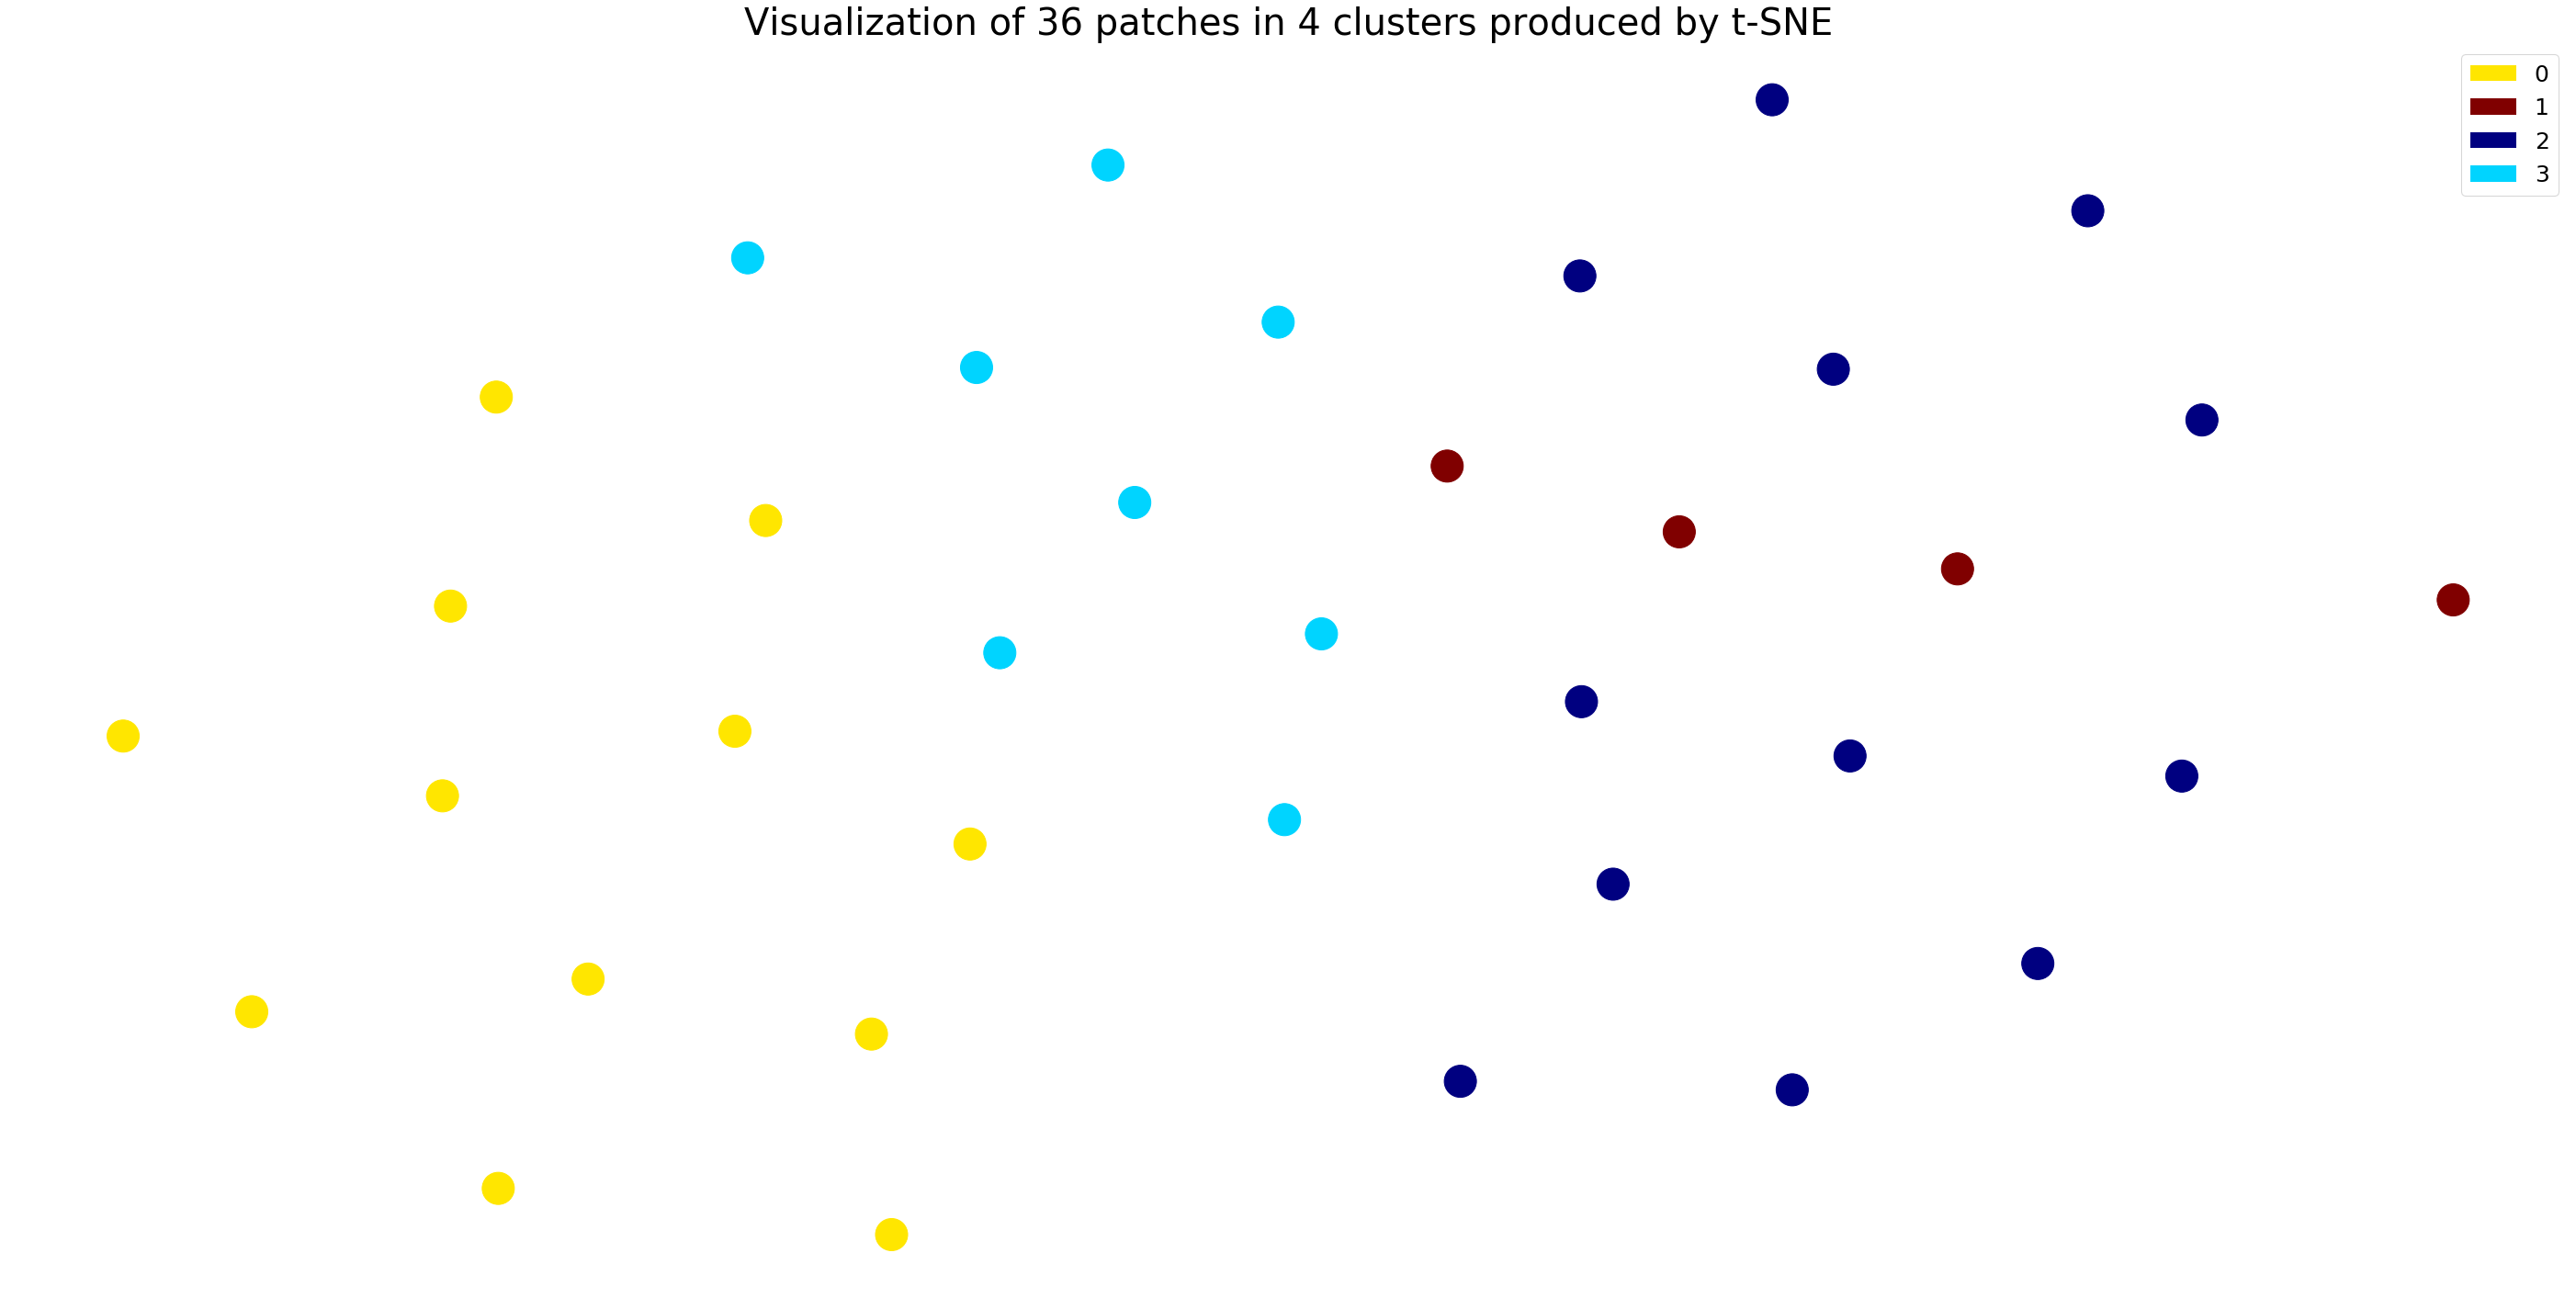

In [217]:
cloud_scatter(cloud_tsne, label)

In [218]:
# cluster_labels = range(num_clusters)
df1 = pd.DataFrame(list(zip(open_clusters, closed_clusters)), 
               columns =['open', 'closed']) 
df1["label"] = [c.label for c in list_clusters]
df1["% open"] = (df1["open"] / (df1["open"] + df1["closed"]))*100
df1["% closed"] = (df1["closed"] / (df1["open"] + df1["closed"]))*100
df1["total"] = (df1["open"] + df1["closed"])
df1

,open,closed,label,% open,% closed,total
0,0,12,0,0.0,100.0,12
1,1,3,1,25.0,75.0,4
2,12,0,2,100.0,0.0,12
3,0,8,3,0.0,100.0,8


In [219]:
def plot_bar():
    save_path = '/home/rubywerman/cluster_plots1/tables/'
    # this is for plotting purpose
    plt.figure(figsize=(100,100))
    fig, ax = plt.subplots()
    index=["C-" + str(i) for i in range(num_clusters)]
    num_patches = df1["total"]
    ax.bar(index,num_patches, width=1.0, edgecolor="#22588a", lw=3)
    ax.invert_yaxis()
    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis.tick_top()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(to_save + '%d_bars.png'%(num_clusters))
    #plt.savefig('/home/rubywerman/to_export/' + str(num_clusters) + '/bar_12')
    plt.show()
    
def plot_sorted_bar():
    save_path = '/home/rubywerman/cluster_plots1/tables/'
    sorted_lc = sorted(list_clusters, key=lambda c: len(c.patches), reverse=True)
    # this is for plotting purpose
    plt.figure(figsize=(100,100))
    fig, ax = plt.subplots()
    index=["C-" + str(c.label) for c in sorted_lc]
    num_patches = [len(c.patches) for c in sorted_lc]
    ax.bar(index,num_patches, width=1.0, color = "#ff9ee8", edgecolor="#e084cb", lw=3)
    ax.invert_yaxis()
    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis.tick_top()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(to_save + '%d_sorted_bars.png'%(num_clusters))

    #plt.savefig('/home/rubywerman/to_export/' + str(num_clusters) + '/bar_12_sorted')
    plt.show()

<Figure size 7200x7200 with 0 Axes>

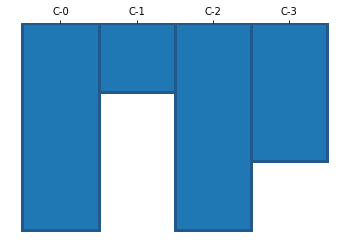

<Figure size 7200x7200 with 0 Axes>

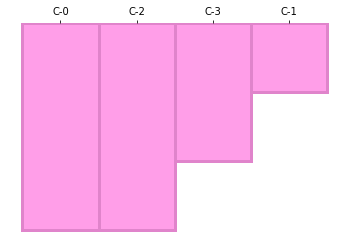

In [220]:
plot_bar()
plot_sorted_bar()

### Inspect certain clusters

In this section, look at the actual patch images that make up each cluster. Here is an opportunity to clean any bad patches out of the data and update your patch files accordingly.

In [221]:
import math

In [222]:
def get_open_patches(cluster_num):
    """
    returns the list of open patches from a cluster
    
    Inputs:
    cluster_num: an int value that refers to the number of the cluster
    
    Outputs:
    o_list_pics: a list of patch image data where the patches are labeled open
    """
    open_in_cluster = [patch for patch in list_clusters[cluster_num].patches if patch.isOpen]
    o_list_pics = []
    for i in range(len(open_in_cluster)):
        p = open_in_cluster[i]
        o_list_pics.append(p.thirtyFive[p.coords[0]*128:p.coords[1]*128,p.coords[2]*128:p.coords[3]*128])
    return o_list_pics

def get_closed_patches(cluster_num):
    """
    returns the list of closed patches from a cluster
    
    Inputs:
    cluster_num: an int value that refers to the number of the cluster
    
    Outputs:
    c_list_pics: a list of patch image data where the patches are closed
    """
    closed_in_cluster = [patch for patch in list_clusters[cluster_num].patches if not patch.isOpen]
    c_list_pics = []
    for i in range(len(closed_in_cluster)):
        p = closed_in_cluster[i]
        c_list_pics.append(p.thirtyFive[p.coords[0]*128:p.coords[1]*128,p.coords[2]*128:p.coords[3]*128])
    return c_list_pics

In [225]:
def show_all_patches():
    """
    creates a grid of displaying which patches are in which clusters, visualization tool
    
    Inputs: 
    None
    
    Outputs:
    None, displayes a grid of patches organized by cluster
    """
    #set rows to the max amount of patches in any of the clusters
    #set cols to the number of clusters (one column for each cluster)
    rows = len(max(list_clusters, key=lambda c: len(c.patches)).patches)
    cols = num_clusters
    
    #create plot
    f, axarr = plt.subplots(rows,cols,figsize=(30,70))

    for c in range(cols):
        axarr[0,c].set_title(str(c), fontsize=70)
        arr = get_open_patches(c) + get_closed_patches(c)

        if len(arr) == 1:
            axarr[0,c].imshow(arr[0])
            axarr[0,c].axis('off')
            for r in range(1, rows):
                plt.delaxes(axarr[r][c])
        else:
            arr_iter = iter(arr)
            for r in range(rows):
                try:
                    axarr[r,c].imshow(next(arr_iter))
                    axarr[r,c].axis('off')
                except:
                    while r < rows:
                        plt.delaxes(axarr[r][c])
                        r += 1
                    break
    plt.savefig(to_save + '%d_patch_pics.png'%(num_clusters))
    plt.show()

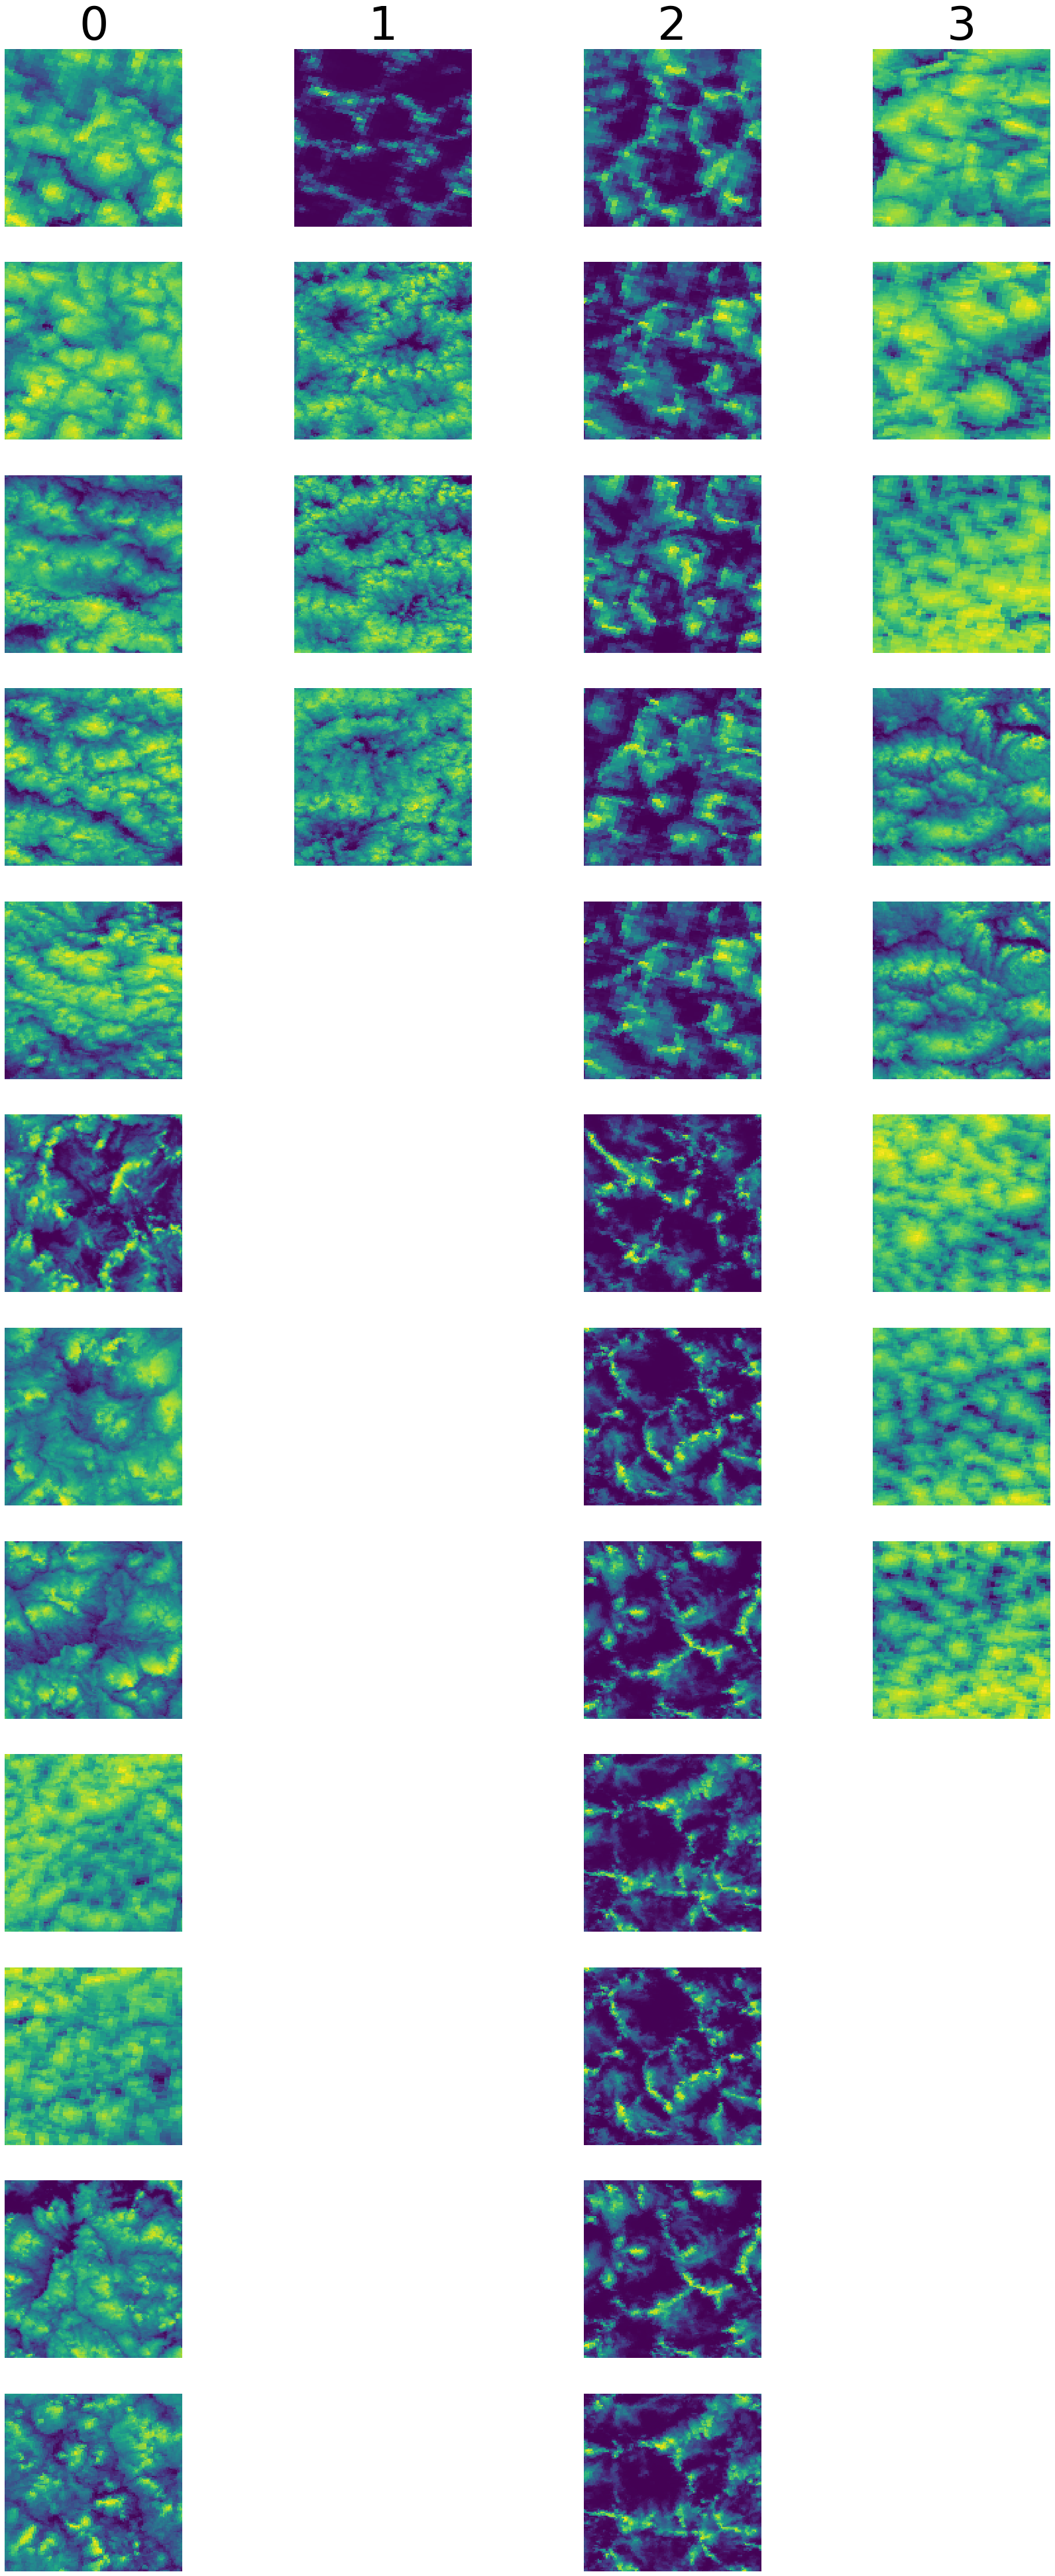

In [226]:
show_all_patches()

In [545]:
def show_patch_grid(cluster_num, isOpen):
    """
    creates a grid of open/closed patches labeled with an index for the purpose of easily identifying bad patches and removing them in the following section of this notebook
    
    Inputs:
    cluster_num: an int value that refers to the number of the cluster
    isOpen: a boolean value that is True if the patches are open, and False if the patches are closed
    
    Outputs:
    None: images of each patch in each cluster
    """
    if isOpen:
        arr = get_open_patches(cluster_num)
        strs = "open"
    else:
        arr = get_closed_patches(cluster_num)
        strs = "closed"

    if len(arr) == 1:
        plt.imshow(arr[0])
        plt.axis('off')
        plt.title('Cluster %d %s'%(cluster_num, strs), fontsize=20)
        plt.ylabel('0')
        plt.show()
        
    elif len(arr) > 0:
        row = col = math.ceil(math.sqrt(len(arr))) 
        arr_iter = iter(arr)
        nums = iter(range(len(arr)))
        
        f, axarr = plt.subplots(row,col, figsize=(10,10))
        plt.subplots_adjust(hspace=.1)
        for r in range(row):
            for c in range(col):
                try:
                    axarr[r,c].imshow(next(arr_iter))
                    axarr[r,c].axis('off')
                    axarr[r,c].set_title('%d'%(next(nums)), fontsize=10)
                except:
                    while r < row:
                        while c < col:
                            plt.delaxes()
                            c += 1
                        r += 1
                    break
        plt.subplots_adjust(wspace=None, hspace=None)
        f.suptitle('Cluster %d %s'%(cluster_num, strs), fontsize=20)
        plt.show()

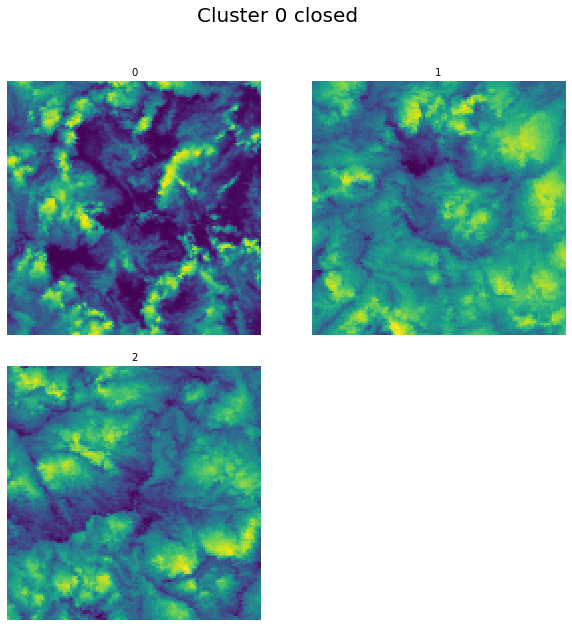

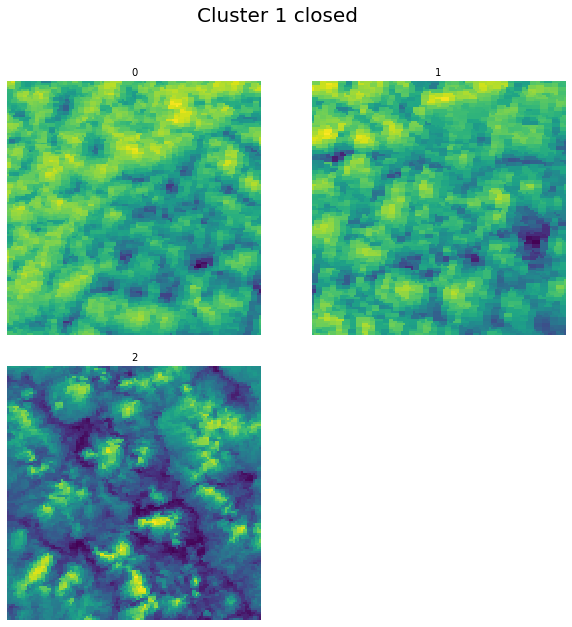

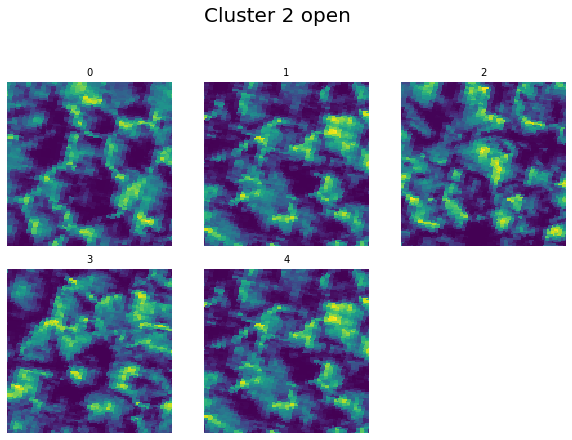

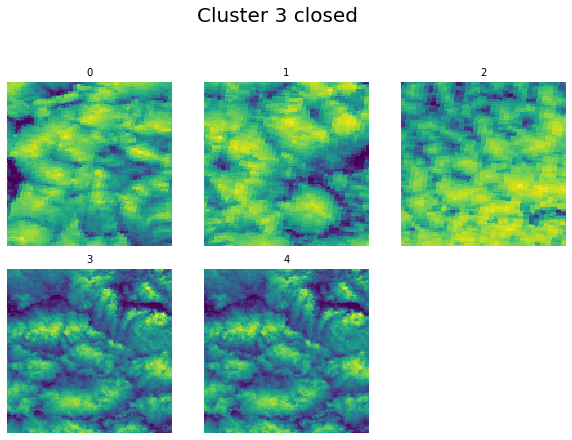

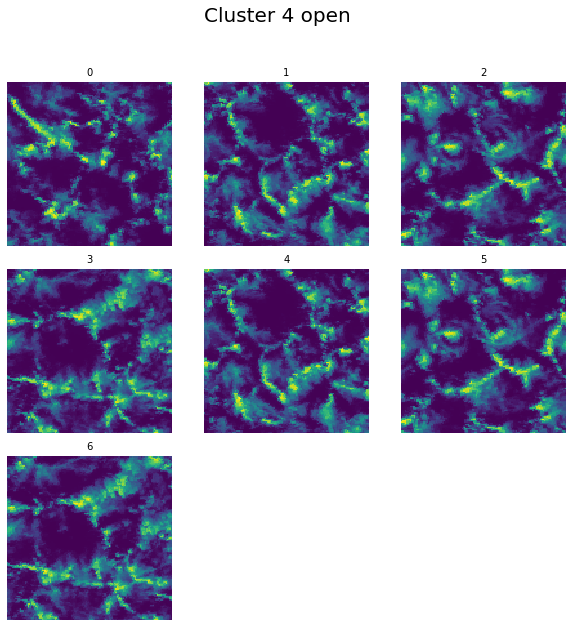

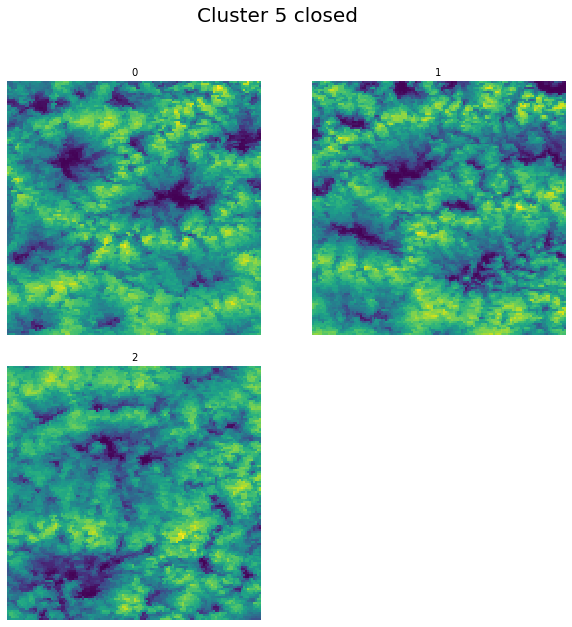

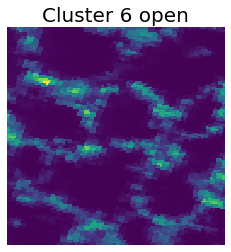

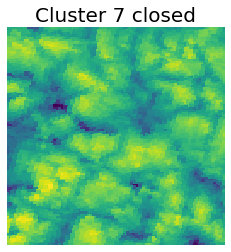

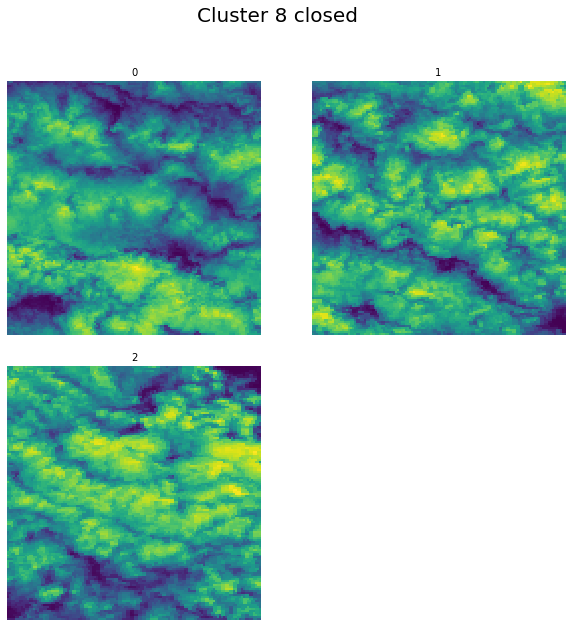

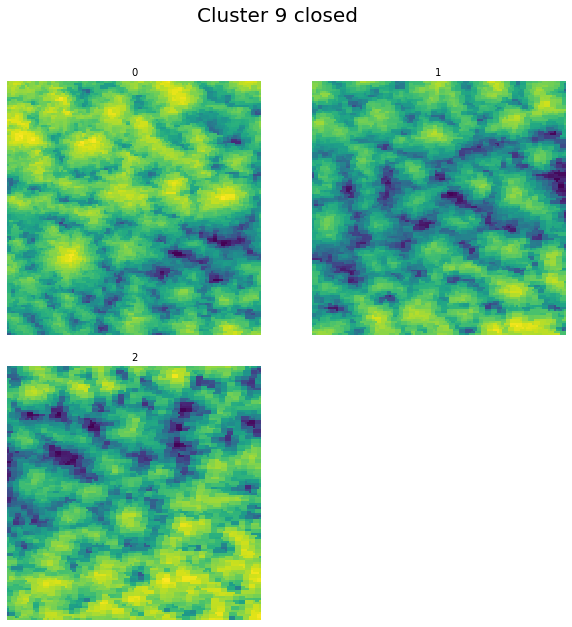

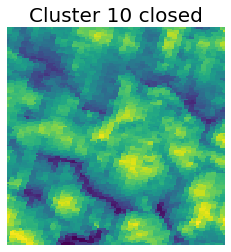

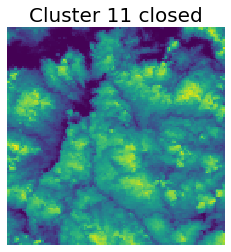

In [546]:
#display the patch groupings for every cluster
for i in range(num_clusters):
    show_patch_grid(i, isOpen=True)
    show_patch_grid(i, isOpen=False)

## Remove bad patches

In [ ]:
def remove_closed(cluster_num, indices):
    """
    removes desired patches from the cluster object's patch list
    
    Inputs: 
    cluster_num: an int value referring to the number of the cluster
    indicies: an int array referring to the patch labels (as listed by the cell above) to be removed
    
    Outputs:
    None. Updates the contents of the cluster.
    """
    cluster = list_clusters[cluster_num]
    closed = [p for p in cluster.patches if not p.isOpen]
    to_save = [p for p in cluster.patches if p.isOpen]
    updated = to_save
    for i in range(len(closed)):
        if i not in indices:
            updated.append(cluster.patches[i])
    cluster.patches = updated
#removes desired patches from the cluster object's patch list
def remove_open(cluster_num, indices):
    """
    removes desired patches from the cluster object's patch list
    
    Inputs: 
    cluster_num: an int value referring to the number of the cluster
    indicies: an int array referring to the patch labels (as listed by the cell above) to be removed
    
    Outputs:
    None. Updates the contents of the cluster.
    """
    cluster = list_clusters[cluster_num]
    to_save = [p for p in cluster.patches if not p.isOpen]
    openx = [p for p in cluster.patches if p.isOpen]
    updated = to_save
    for i in range(len(openx)):
        if i not in indices:
            updated.append(cluster.patches[i])
    cluster.patches = updated

Create an updated patch list named `cleaned_patches`.

In [ ]:
cleaned_patches = []
for c in list_clusters:
    if c.patches:
        cleaned_patches.extend(c.patches)

In [ ]:
#write new date data
updated_open_dates = set()
updated_closed_dates = set()
for p in cleaned_patches:
    if p.isOpen:
        updated_open_dates.add(p.date)
    else:
        updated_closed_dates.add(p.date)       

Call the `save()` function below to write new updated date files and a file of patches stored in a list of patch instances.

In [ ]:
np.save('/home/rubywerman/clouds/src_analysis/labeled_data/class_patch_data/072219.npy', cleaned_patches)

# Visualize clustering on cleaned patches

Below you can re-cluster the patches and see how the clustering differs through visualization.

In [ ]:
encs_list1 = []
for patch in cleaned_patches:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list1 += [encs.mean(axis=(1,2))]
        
features1 = np.concatenate(encs_list1, axis=0)

In [44]:
clustering1 = AgglomerativeClustering(num_clusters)
cleaned_features1 = np.nan_to_num(features1)
label1 = clustering1.fit_predict(cleaned_features1)

In [45]:
##NOTE: reassigns patch labels!
for i in range(len(cleaned_patches)):
    cleaned_patches[i].label = label1[i]

list_clusters1 = [Cluster(label=i) for i in range(num_clusters)]

for p in cleaned_patches:
    matching_cluster1 = list_clusters1[p.label]
    if p.isOpen:
        matching_cluster1.num_open += 1
    if not matching_cluster1.patches:
        matching_cluster1.patches = [p]
    else:
        matching_cluster1.patches.append(p)

for c in list_clusters1:
    c.means = get_band_means(c.patches)
    c.std = get_band_std(c.patches)
    
open_clusters1 = [i.num_open for i in list_clusters1]
closed_clusters1 = [len(i.patches) - i.num_open for i in list_clusters1]

/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


W0723 09:29:16.577935 139898155169600 legend.py:1282] No handles with labels found to put in legend.


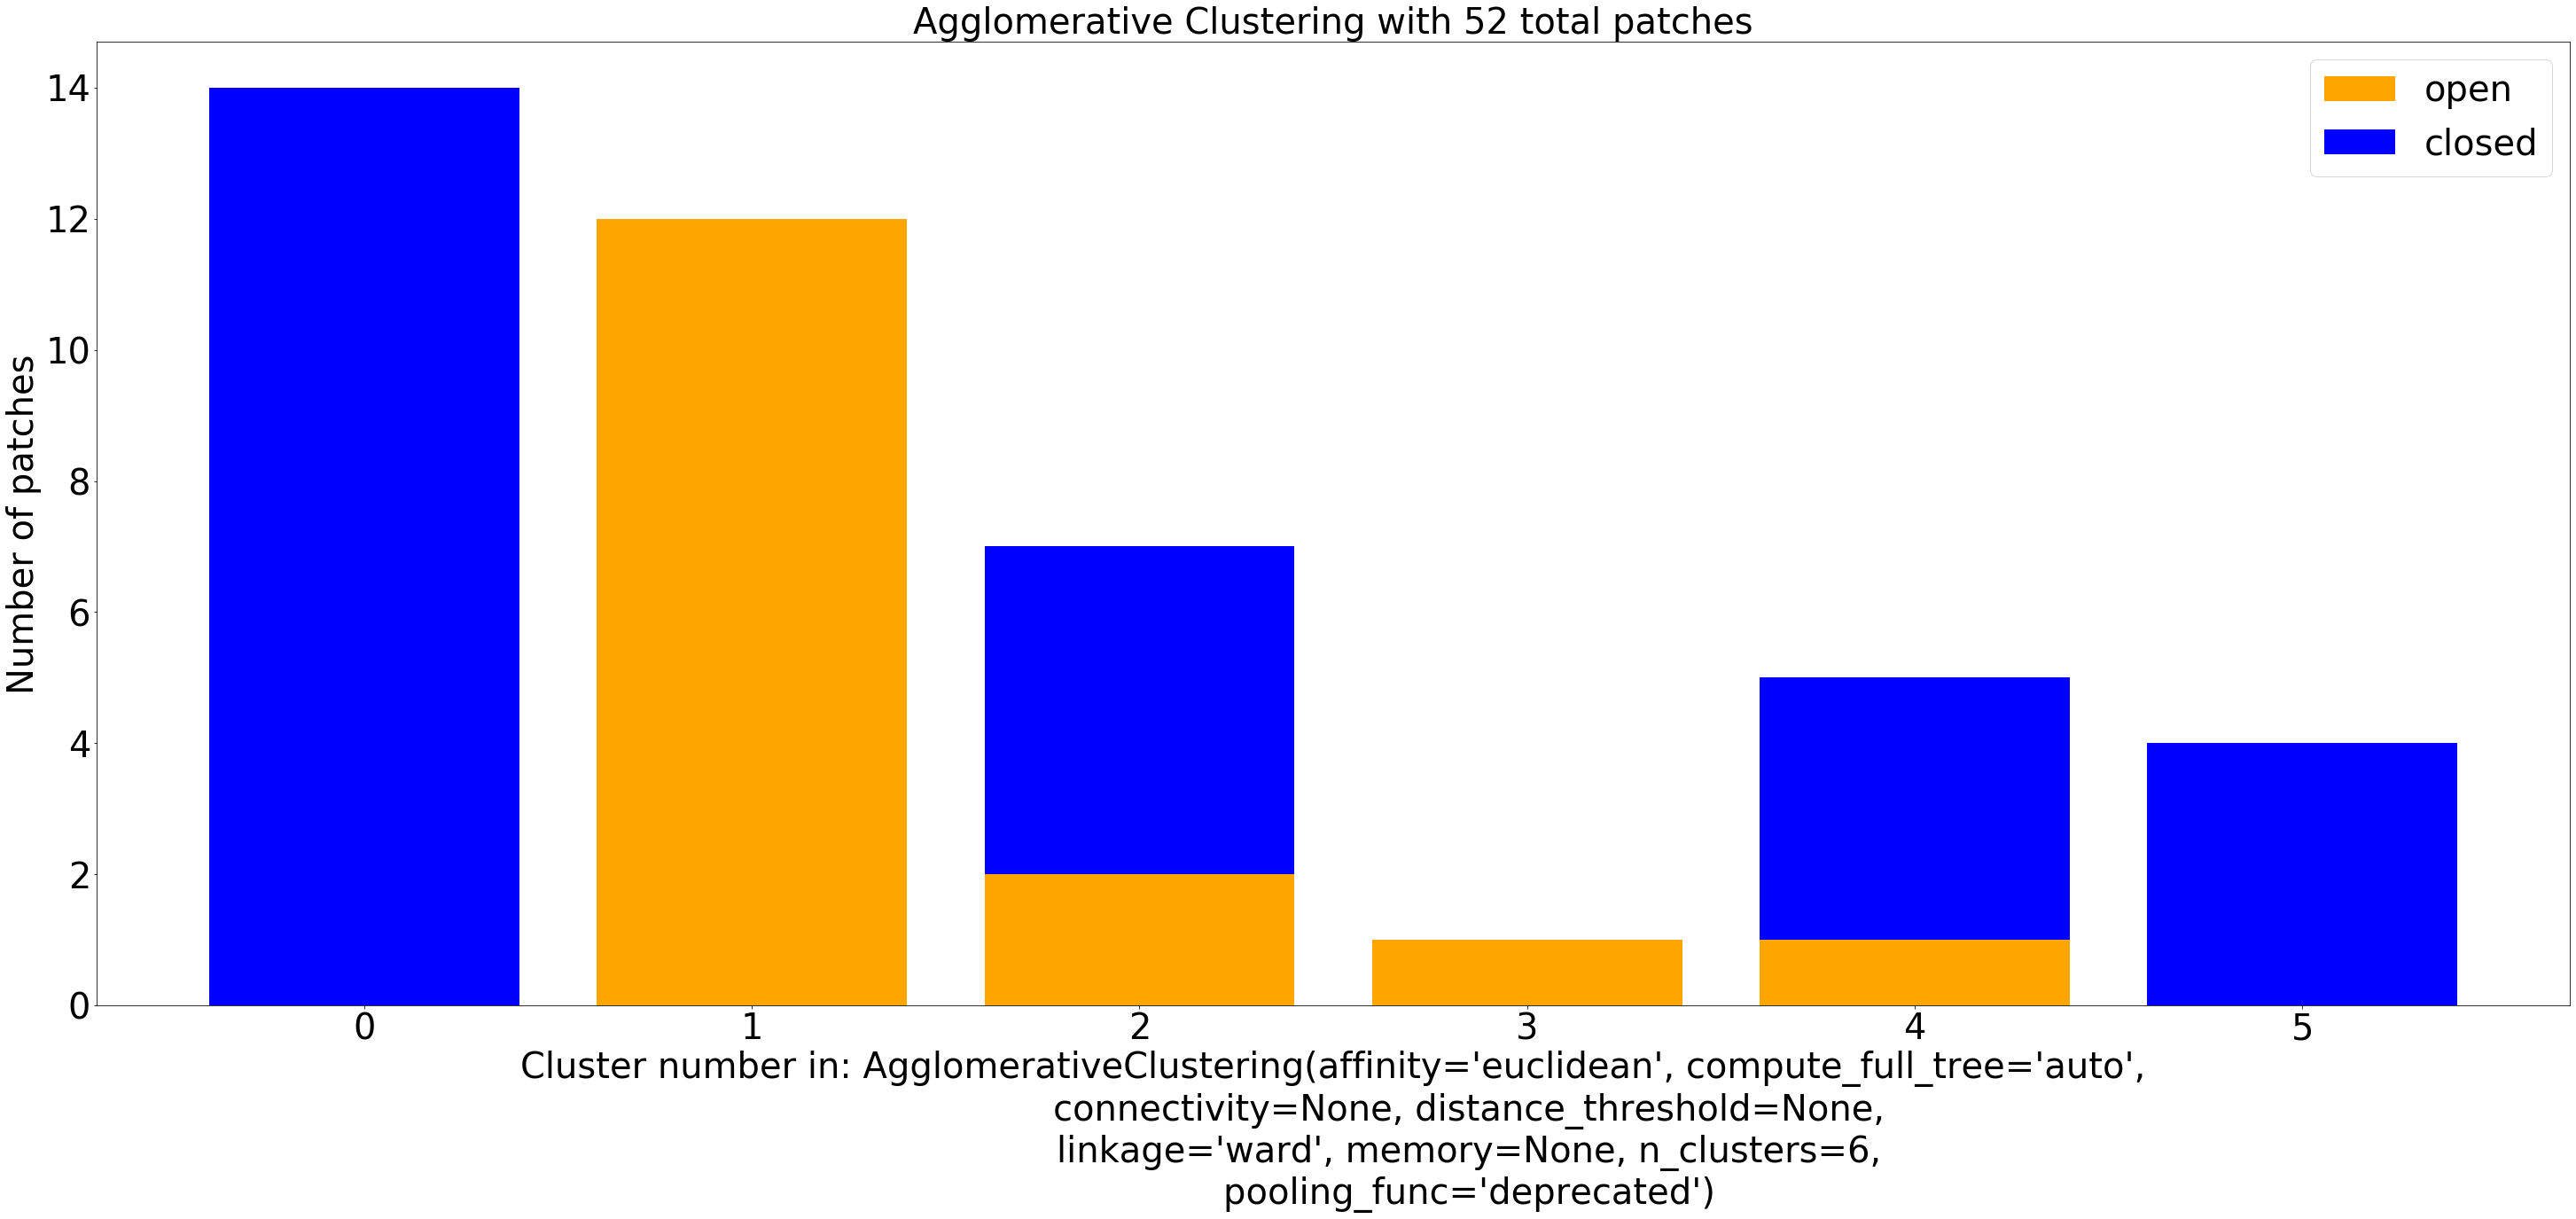

In [46]:
#create stacked bar graph 
plt.figure(figsize=(50,20))

# Heights of bars
bars = [len(open_clusters1), len(closed_clusters1)]

# The position of the bars on the x-axis
r = range(num_clusters)

# Label for each bar and bar width
x_labels = [str(i) for i in r]
barWidth = .8

# Create open-classified bars
plt.bar(r, open_clusters1, color='orange', width=barWidth)

# Stack bars
plt.bar(r, closed_clusters1, bottom=open_clusters1, color='blue', width=barWidth)

# label/title graph
plt.xticks(r, x_labels, fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel("Number of patches", fontsize=40)
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
plt.legend(loc="upper right")
plt.legend(('open','closed'), fontsize=40)
plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
plt.show()

In [47]:
df1["cleaned open"] = open_clusters1
df1["cleaned closed"] = closed_clusters1
df1["cleaned % open"] = (df1["cleaned open"] / (df1["cleaned open"] + df1["cleaned closed"]))*100
df1["cleaned % closed"] = (df1["cleaned closed"] / (df1["cleaned open"] + df1["cleaned closed"]))*100
df1

,open,closed,% open,% closed,cleaned open,cleaned closed,cleaned % open,cleaned % closed
0,0,12,0.000000,100.000000,0,14,0.000000,100.000000
1,3,3,50.000000,50.000000,12,0,100.000000,0.000000
2,2,10,16.666667,83.333333,2,5,28.571429,71.428571
3,7,0,100.000000,0.000000,1,0,100.000000,0.000000
4,1,0,100.000000,0.000000,1,4,20.000000,80.000000
5,4,10,28.571429,71.428571,0,4,0.000000,100.000000


# Stuff to do, stuff to organize

Below is some unfinished code that will eventually create a distribution of mean intensity per patch

In [716]:
# visualize std for each band for each cluster
n_groups = 6

def get_cluster_means(list_clusters, i):
    return list_clusters[i].means

def get_cluster_std(list_clusters, i):
    return list_clusters[i].std

<Figure size 3600x3600 with 0 Axes>

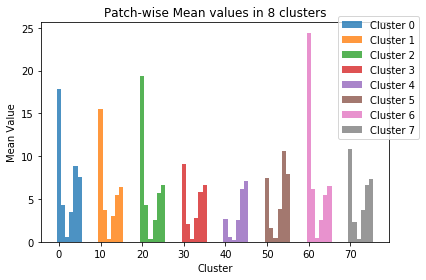

In [745]:
# create plot
f = plt.figure(figsize=(50,50))

fig, ax = plt.subplots()
index = bar_width*np.arange(n_groups)
bar_width = 1
opacity = 0.8


for i in range(num_clusters):
    plt.bar(index + bar_width*i*10, get_cluster_means(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

plt.xlabel('Cluster')
#plt.xticks(range(num_clusters))

plt.ylabel('Mean Value')
plt.title('Patch-wise Mean values in %d clusters'%num_clusters)
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()


<Figure size 1440x216 with 0 Axes>

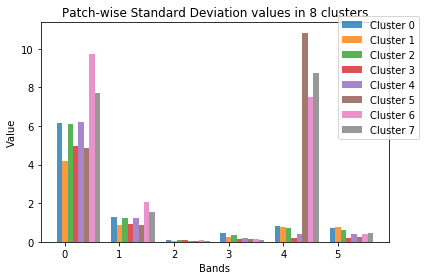

In [507]:
# visualize std for each band for each cluster
n_groups = 6

# create plot
f = plt.figure(figsize=(20,3))

fig, ax = plt.subplots()
index = 10*np.arange(n_groups)
bar_width = 1
opacity = 0.8

#make bars for each cluster
for i in range(num_clusters):
    plt.bar(index + bar_width*i, get_cluster_std(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

#set axes
plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Patch-wise Standard Deviation values in %d clusters'%num_clusters)
plt.xticks(index + bar_width, range(6))
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()

In [131]:

        
#generates list of 6 means for each band in the patch list 
def get_band_means(patch_list):
    mean_list = []
    for i in range(6):
        mean_list.append(np.nanmean([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return mean_list

#generates list of 6 stds for each band in the patch list 
def get_band_std(patch_list):
    std_list = []
    for i in range(6):
        std_list.append(np.nanstd([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return std_list